# Interpretable ML

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Interpretable models

An interpretable model is one whose decisions humans can understand. Some models such as linear models with a small number of variables, or decision trees with limited depth, are intrinsically interpretable. Others such as ensembles, high-dimensional support vector machines or neural networks are essentially *black boxes*. Interpretable ML studies how to make *black box* models comprehensible to humans, typically by showing how a few key features influence the machine prediction.

Interpretable ML can be *local* and tell us something about how a machine makes a prediction for a particular instance, or *global*. Recently, there has been much interest in model-agnostic interpretable ML that can provide interpretation for multiple ML families (e.g. trees, support vector machines and neural nets).

Reference:

[Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)

## Intrinsically interpretable models

In [2]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv').squeeze()
y_test = pd.read_csv('data/y_test.csv').squeeze()

### Decision trees

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [4]:
dt_gini = DecisionTreeClassifier(max_depth=2, criterion='gini', random_state=0)

In [5]:
dt_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

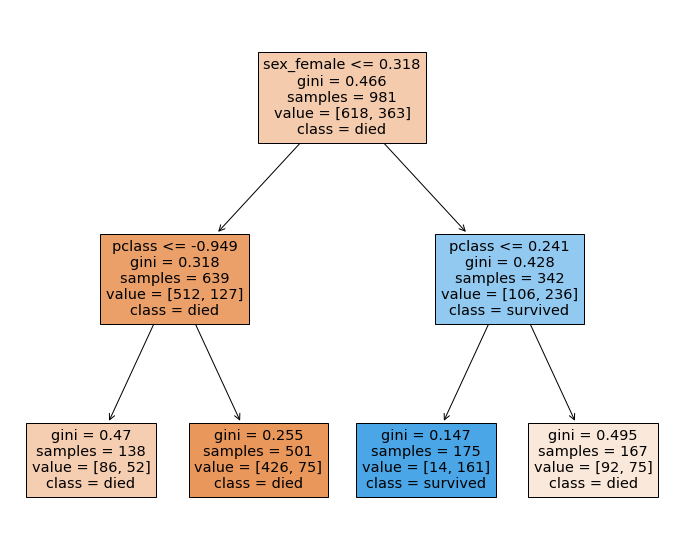

In [6]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
tree.plot_tree(dt_gini, 
               feature_names=X_train.columns,  
               class_names=['died', 'survived'],
               filled=True,
               ax = ax);

#### Gini coefficient

$$
1 - \sum{p_i^2}
$$

In [7]:
n1 = np.array([618, 363])
p1 = n1 / n1.sum()

In [8]:
gini = 1 - (p1**2).sum()
gini

0.4662159002702728

The Gini coefficient can be thought of as the degree of *impurity* - for two classes, we can see that the Gini coefficient reaches its maximum when both classes are equally represented.

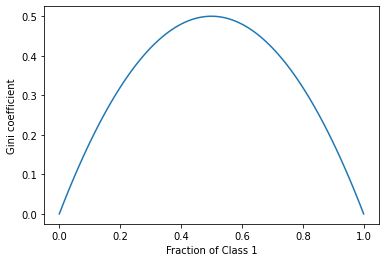

In [9]:
p = np.linspace(0, 1, 101)
ps = np.array([p, 1-p])
plt.plot(p, 1 - (ps**2).sum(axis=0))
plt.xlabel('Fraction of Class 1')
plt.ylabel('Gini coefficient');

#### Entropy or Information Gain

$$
- \sum{p_i \log(p_i)}
$$

In [10]:
dt_gain = DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=0)

In [11]:
dt_gain.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0)

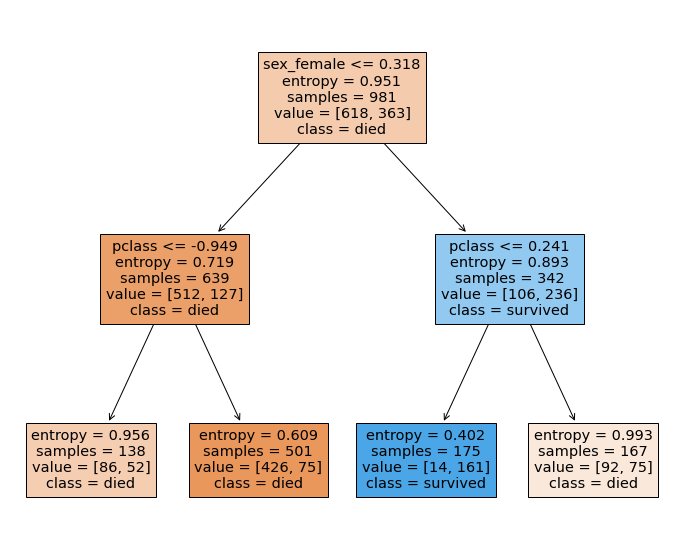

In [12]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
tree.plot_tree(dt_gain, 
               feature_names=X_train.columns,  
               class_names=['died', 'survived'],
               filled=True,
               ax = ax);

In [13]:
entropy = -(np.log2(p1) * p1).sum()

In [14]:
entropy

0.9506955707275353

The entropy can be thought of as a measure of *surprise* - it behaves quite similalriy to the Gini coefficinet.

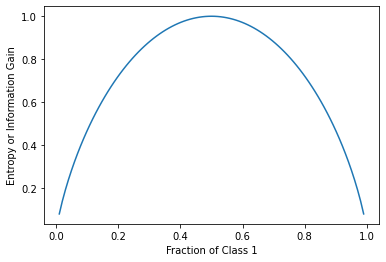

In [15]:
p = np.linspace(0.01, 0.99, 101)
ps = np.array([p, 1-p])
plt.plot(p, -np.sum(np.log2(ps)*ps, axis=0))
plt.xlabel('Fraction of Class 1')
plt.ylabel('Entropy or Information Gain');

### Linear models 

#### Logistic regression

For logistic regression, the log odds is a linear model

$$
\log\left(\frac{P(y = 1)}{1 - P(y=1)}\right) = \beta + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_k x_k
$$

So if we can think in terms of log odds as outcomes, then the contribution of a feature to the outcome is simply the feature coefficient multiplied by the value of the feature. This does not depend on how the feature is scaled, though of course the coefficients will be affected by scaling. 

In [16]:
from sklearn.linear_model import LogisticRegression

We set C to be a large value to minimize regularization

In [17]:
lr = LogisticRegression(C=1e6)

Since we are running vanilla logistic regression, we will remove collinear columns

In [18]:
X_train_ = X_train.drop(columns=['sex_male', 'embarked_'])
X_test_ = X_test.drop(columns=['sex_male', 'embarked_'])

In [19]:
lr.fit(X_train_, y_train)

LogisticRegression(C=1000000.0)

In [20]:
x0 = X_test_.iloc[0:1,:]

In [21]:
p = lr.predict_proba(x0)[0]

In [22]:
p

array([0.32298413, 0.67701587])

In [23]:
lr.coef_

array([[-0.94130541,  1.1544841 , -0.53540898, -0.42239517, -0.01071746,
         0.03766308, -4.10792748, -4.89538552, -3.10246539]])

In [24]:
β0 = lr.intercept_

In [25]:
β = lr.coef_

In [26]:
print(f'{(β0 + x0 @ β.T)[0][0]:.4f}')

0.7401


In [27]:
print(f'{(np.log(p[1]/p[0])):.4f}')

0.7401


In [28]:
import seaborn as sns

In [29]:
importance = (x0 * β).T

In [30]:
importance.sort_values(0, ascending=False, key=lambda x: np.abs(x))

,0
embarked_S,-3.249181
embarked_C,2.130908
sex_female,1.578067
embarked_Q,0.992048
pclass,-0.786542
age,0.602954
sibsp,0.194085
fare,-0.018147
parch,0.004692


### Surrogate models

One simple approach is to use an interpretable model to help interpret a black box model. This is done by replacing the target with the prediction of the black box model when training the interpretable model.

In this example, we use a shallow decision tree to interpret a Support Vector Classifier.

In [31]:
from sklearn.svm import SVC

In [32]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_train)

In [33]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_pred)

DecisionTreeClassifier(max_depth=2)

In [34]:
dt.score(X_train, y_pred)

0.9153924566768603

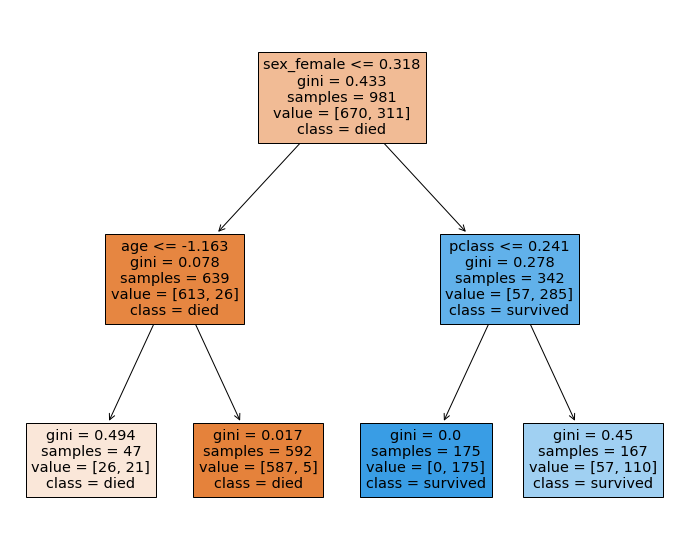

In [35]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
tree.plot_tree(dt, 
               feature_names=X_train.columns,  
               class_names=['died', 'survived'],
               filled=True,
               ax = ax);

## Model Agnostic Methods

### Partial dependence plot

Partial dependence plots show the dependence between the objective function and selected features, marginalizing over the values of all other features.

In [36]:
from sklearn.inspection import plot_partial_dependence

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [39]:
list(zip(range(12), X_train.columns))

[(0, 'pclass'),
 (1, 'sex_male'),
 (2, 'sex_female'),
 (3, 'age'),
 (4, 'sibsp'),
 (5, 'parch'),
 (6, 'fare'),
 (7, 'embarked_C'),
 (8, 'embarked_S'),
 (9, 'embarked_Q'),
 (10, 'embarked_')]

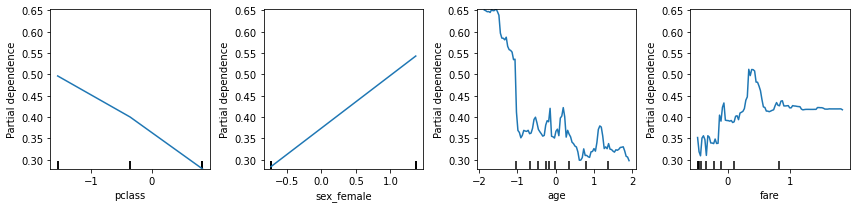

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
plot_partial_dependence(rf, X_train, [0,2,3,6, ], ax=ax)
plt.tight_layout()

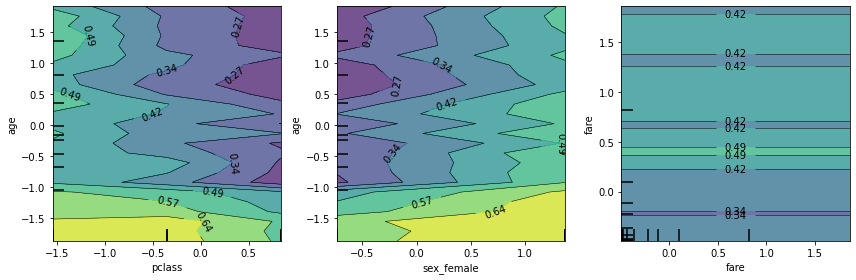

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plot_partial_dependence(rf, X_train, [(0,3), (2,3), (6,6)], 
                        grid_resolution=25, ax=ax)
plt.tight_layout()

### Permutation importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.

In [42]:
from sklearn.inspection import permutation_importance

In [43]:
r = permutation_importance(rf, 
                           X_test, 
                           y_test,
                           n_repeats=30,
                           random_state=0)

In [44]:
(
    pd.DataFrame(zip(X_test.columns, r.importances_mean), 
             columns=['Feature', 'Permutation Importance']).
    sort_values('Permutation Importance', key=lambda x: -np.abs(x))
)

,Feature,Permutation Importance
2,sex_female,0.127033
1,sex_male,0.054980
0,pclass,0.049492
3,age,0.039837
8,embarked_S,-0.011179
7,embarked_C,-0.009248
9,embarked_Q,-0.009248
6,fare,0.005081
4,sibsp,-0.002744
5,parch,-0.002337


#### Impurity-based importances

See [here](https://scikit-learn.org/stable/modules/permutation_importance.html#relation-to-impurity-based-importance-in-trees) for discussion of differences, and why permutation based importance is preferable.

In [45]:
(
    pd.DataFrame(zip(X_test.columns, rf.feature_importances_), 
             columns=['Feature', 'Permutation Importance']).
    sort_values('Permutation Importance', key=lambda x: -np.abs(x))
)

,Feature,Permutation Importance
3,age,0.296380
6,fare,0.260428
2,sex_female,0.140575
1,sex_male,0.092056
0,pclass,0.084108
4,sibsp,0.047764
5,parch,0.043629
7,embarked_C,0.018407
8,embarked_S,0.010869
9,embarked_Q,0.005739


### Shapley Additive exPlanations (SHAP)

### Shapley values

A concept from game theory - Nobel Prize in Economics 2012

In the ML context, the game is prediction of an instance, each player is a feature, coalitions are subsets of features, and the game payoff is the difference in predicted value for an instance and the mean prediction (i.e. null model with no features used in prediction).

The Shapley value is given by the formula

![img](https://wikimedia.org/api/rest_v1/media/math/render/svg/6fe739cf2e00ee18336b028ada7971d124e63f2b)

We will give a simple example - suppose there are 3 features $a$, $b$ and $c$ used in a regression problem. The figure shows the possible coalitions, where the members are listed in the first line and the predicted value for the outcome using just that coalition in the model is shown in the second line.

![img](figs/shapley.png)

Let's work out the Shapley value of feature $a$. First we work out the weights

![img](figs/shapley1.png)

The red arrows point to the coalitions where $a$ was added (and so made a contribution). To figure out the weights there are 2 rules:

- The total weights for a feature sum to 1
- The total weights on each row are equal to each other. Since there are 3 rows, the total weight of each row sums to $1/3$
- All weights within a row are equal - since the second row has two weights, each weight must be $1/6$

Now we multiply the weights by the marginal contributions - the value minus the coalition without that feature. So we have

$$
\psi_a(v) = \frac{1}{3}(105-100) + \frac{1}{6}(125-120) + \frac{1}{6}(100-90) + \frac{1}{3}(115-130) \\
\psi_b(v) = \frac{1}{3}(90-100) + \frac{1}{6}(100-105) + \frac{1}{6}(130-120) + \frac{1}{3}(115-125) \\
\psi_c(v) = \frac{1}{3}(120-100) + \frac{1}{6}(125-105) + \frac{1}{6}(130-90) + \frac{1}{3}(115-100) \\
$$

### SHAP

Shapley Additive exPlanations.  Note that the sum of Shapley values for all features is the same as the difference between the predicted value of the full model (with all features) and the null model (with no features). So the Shapley values provide an *additive* measure of feature importance. In fact, we have a simple linear model that explains the contributions of each feature.

- Note 1: The prediction is for each instance (observation), so this is a local interpretation. However, we can average over all observations to get a global value.
- Note 2: There are $2^n$ possible coalitions of $n$ features, so exact calculation of the Shapley values as illustrated is not feasible in practice. See the reference book for details of how calculations are done in practice.
- Note 3: Since Shapley values are additive, we can just add them up over different ML models, making it useful for ensembles.
- Note 4: Strictly, the calculation we show is known as kernelSHAP. There are variants for different algorithms that are faster such as treeSHAP, but the essential concept is the same.
- Note 5: The Shapeley values quantify the contributions of a feature when it is added to a coalition. This measures something different from the permutation feature importance, which assesses the loss in predictive ability when a feature is removed from the feature set.


In [46]:
va = 1/3*(105-100) + 1/6*(125-120) + 1/6*(100-90) + 1/3*(115-130)
vb = 1/3*(90-100) + 1/6*(100-105) + 1/6*(130-120) + 1/3*(115-125)
vc = 1/3*(120-100) + 1/6*(125-105) + 1/6*(130-90) + 1/3*(115-100)

In [47]:
va, vb, vc

(-0.8333333333333339, -5.833333333333332, 21.666666666666664)

In [48]:
va + vb + vc

14.999999999999998

### The `shap` package

In [49]:
import shap

In [50]:
shap.initjs()

#### TreeSHAP parameters

Note: It is easier to interpret a model if the features are on their original scale. Since tree-based algorithms are not sensitive to scaling, we will use the unscaled data sets for this section. We will also drop redundant columns.

#### Load unscaled data

In [51]:
X_train = pd.read_csv('data/X_train_unscaled.csv')
X_test = pd.read_csv('data/X_test_unscaled.csv')
y_train = pd.read_csv('data/y_train_unscaled.csv').squeeze()
y_test = pd.read_csv('data/y_test_unscaled.csv').squeeze()

In [52]:
X_train.columns

Index(['pclass', 'sex_male', 'sex_female', 'age', 'sibsp', 'parch', 'fare',
       'embarked_S', 'embarked_C', 'embarked_Q'],
      dtype='object')

In [53]:
X_train = X_train.drop(columns=['sex_male'])
X_test = X_test.drop(columns=['sex_male'])

#### Train tree ensemble

In [54]:
import xgboost

In [55]:
clf = xgboost.XGBClassifier(
    random_state=0, 
)

In [56]:
clf.fit(X_train, y_train);

In [57]:
clf.score(X_test, y_test)

0.823170731707317

#### Build explainer

In [58]:
explainer = shap.TreeExplainer(
    clf, 
)

In [59]:
sv = explainer.shap_values(X_train)

#### Summary plot

This shows the jittered Shapley values (in probability space) for all instances for each feature. An instance to the right of the vertical line (null model) means that the model predicts a higher probability of survival than the null model. If a point is on the right and is red, it means that for that instance, a high value of that feature predicts a higher probability of survival.

For example, sex_female shows that if you have a high value (1 = female, 0 = male) your probability of survival is increased (c.f. sex_male). Similarly, younger age predicts higher survival probability.

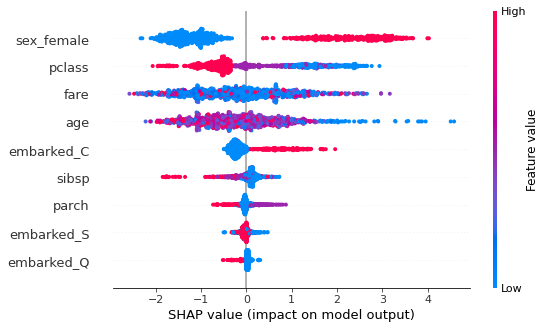

In [60]:
shap.summary_plot(sv, X_train)

Or you can just get an "importance" type bar graph, which shows the mean absolute Shapley value for each feature.

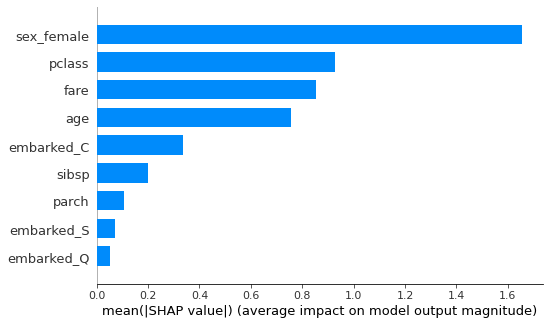

In [61]:
shap.summary_plot(sv, X_train, plot_type='bar')

#### Force plot

We show the forces acting on a single instance (index 10). The model predicts a probability of survival of 0.03, which is lower than the base probability of survival (0.39). The force plot shows which features affect the difference between the full and base model predictions. Blue arrows means that the feature decreases survival probability, red arrows means that the feature increases survival probability.

Predicted probability of survival of base model

In [62]:
p_null = sum(y_train == 1) / len(y_train)
print(f'{p_null:0.2f}')

0.39


Predicted probability of survival of full model for index=0

In [63]:
p0= clf.predict_proba(X_train.iloc[10:11, :])[0, 1]
print(f'{p0:0.2f}')

0.03


In [64]:
X_train.iloc[10, :]

pclass         1.0
sex_female     0.0
age           55.0
sibsp          1.0
parch          1.0
fare          93.5
embarked_S     1.0
embarked_C     0.0
embarked_Q     0.0
Name: 10, dtype: float64

Setting `link='logit'` displays in probability space.

In [65]:
shap.force_plot(
    explainer.expected_value, 
    sv[10, :], 
    X_train.iloc[10, :],
    link = 'logit'
)

You can also combine multiple force plots into a single diagram. When you plot multiple observations, the plot is flipped 90 degrees, and each "column" represents an instance. 

In [66]:
shap.force_plot(
    explainer.expected_value, 
    sv, 
    X_train,
    link='logit'
)

#### Dependence plot

Similar in concept to partial dependency plot, but with Shapley values. It also shows the interaction with the feature with the highest interaction value. 

Note that generally the probability of survival decreases with increasing age. 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


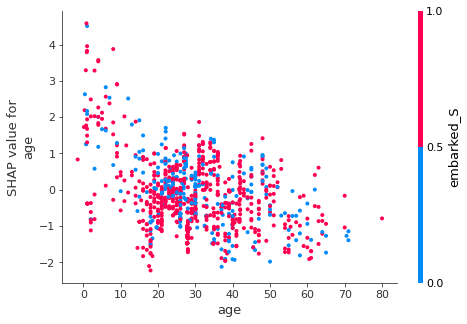

In [67]:
shap.dependence_plot(
    'age', 
    sv, 
    X_train,
)

#### Interaction values

We can explore the interaction between sex and age more carefully.

In [68]:
siv = explainer.shap_interaction_values(X_train)

In [69]:
siv.shape

(981, 9, 9)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


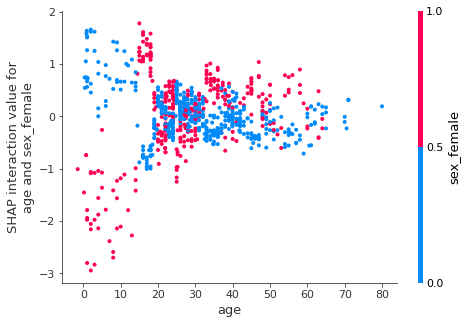

In [70]:
shap.dependence_plot(
    ['age', 'sex_female'],
    siv,
    X_train,
)

#### Decision plots

The decision plot shows how a prediction was made for each instance. The y axis shows the feature values in decreasing order of importance. The baseline is the null model prediction. Here I have plotted every 10th instance to avoid over-crowding the figure.

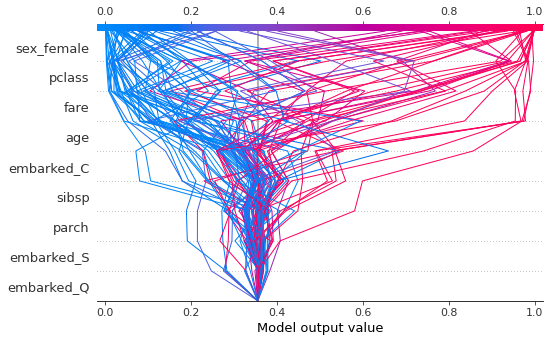

In [71]:
shap.decision_plot(
    explainer.expected_value, 
    sv[::10], 
    feature_names = X_train.columns.tolist(),
    link='logit'
)

You can also view for just one instacne.

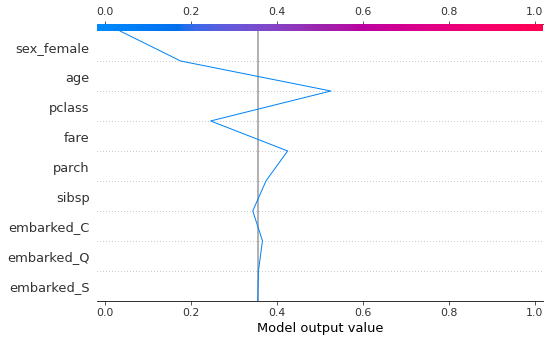

In [72]:
shap.decision_plot(
    explainer.expected_value, 
    sv[10], 
    feature_names = X_train.columns.tolist(),
    link='logit'
)

#### Using marginal contributions

We can set `feature_perturbation='interventional'` so that it will calculate the marginal contributions similar to the description above ; the alternative shown above (default when no data is provided) is `'tree_path_dependent'` which uses conditional rather than marginal contributions  - this is faster and has the advantage that data is not required (just a fitted model), but the additivity property is no longer strictly true.

We set `model_output='probability'` since it is easier to think in terms of probability of survival instead of log odds (set to `'raw'` if you want log odds).

In [73]:
explainer2 = shap.TreeExplainer(
    clf, 
    X_train,
    output = 'probability',
    feature_perturbation='interventional'
)

In [74]:
sv2 = explainer2.shap_values(X_train)

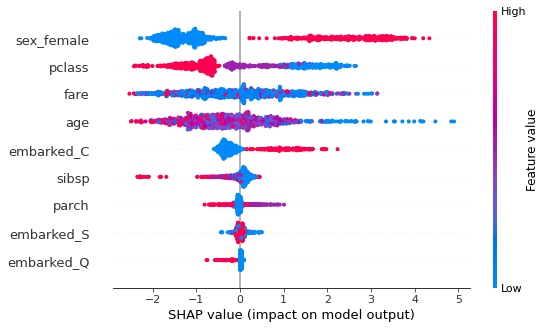

In [75]:
shap.summary_plot(sv2, X_train)